In [50]:
from PIL import Image
import tensorflow as tf 
import numpy as np
import cv2
import time 

In [85]:
sess = tf.compat.v1.InteractiveSession()
# Load image in 
tf_img = tf.keras.preprocessing.image.load_img('dahlia.png')
cols, rows = tf_img.size

# Initialise S 
S = tf.Variable(np.array(tf_img), dtype=np.float32)
S = S.assign(S/256)

size_2D = (rows, cols)
fx = tf.constant([1, -1], dtype=np.int32)

fx = np.int32([[1, -1]])
fy = np.int32([[1], [-1]])

In [86]:
def psf2otf(psf, outSize):
    print(outSize)

    # Determine PSF / OTF shapes
    #psfSize = tf.constant(psf.shape.as_list())
    
    # Pad the PSF to outSize
#     new_psf = tf.Variable(tf.zeros(outSize, dtype=np.int32))
#     tf.scatter_nd_update(new_psf, tf.constant([[0,0]], dtype=np.int32), tf.constant([1], dtype=np.int32))


    psf = np.float32(psf)

    # Determine PSF / OTF shapes
    psfSize = np.int32(psf.shape)

    # Pad the PSF to outSize
    new_psf = np.zeros(outSize, dtype=np.float32)
    
    
    
    new_psf[:psfSize[0],:psfSize[1]] = psf[:,:]
    psf = new_psf
    
    print(new_psf.shape)

    # Circularly shift the OTF so that PSF center is at (0,0)
    shift = -(psfSize / 2)
    
    for i in range(shift.size):
        psf = np.roll(psf, int(shift[i]), axis=i)
    
    otf = np.fft.fftn(psf)
    return otf

In [87]:
otfFx = psf2otf(fx, size_2D)
otfFy = psf2otf(fy, size_2D)

(480, 640)
(480, 640)
(480, 640)
(480, 640)


In [88]:
otfFx = tf.complex(otfFx.real, otfFx.imag)
otfFy = tf.complex(otfFy.real, otfFy.imag)

In [89]:
_lambda = 2e-2
kappa = 2.0

# Compute F(I)
S_complex = tf.Variable(tf.complex(S, tf.constant(tf.zeros((rows, cols, 3)))))
FI = tf.Variable(tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3))))
for i in range(S_complex.shape[2]):
    FI = FI[:,:,i].assign(tf.signal.fft2d(S_complex[:,:,i]))

In [90]:
MTF = tf.math.square(otfFx) + tf.math.square(otfFy)
MTF = tf.stack([MTF, MTF, MTF], axis=2)

In [91]:
# Initialize buffers
# h = tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3)))
# v = tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3)))

h = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float32))
v = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float32))
dxhp = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float32))
dyvp = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float32))
FS = tf.Variable(tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3))))

# # Iteration settings
beta_max = 1e5;
beta = 2 * _lambda
iteration = 0

In [92]:
M = cols
N = rows 

In [93]:
# Iterate until desired convergence in similarity
while beta < beta_max:
    
    h = tf.Variable(h)
    v = tf.Variable(v)

    # compute dxSp
    h = h[:,0:M-1,:].assign(tf.math.real(S_complex[:,1:]-S_complex[:,:-1]))
    h = h[:,M-1:M,:].assign(tf.math.real(S_complex[:,0:1,:] - S_complex[:,M-1:M,:]))

    # compute dySp
    v = v[0:N-1,:,:].assign(tf.math.real(S_complex[1:]-S_complex[:-1]))
    v = v[N-1:N,:,:].assign(tf.math.real(S_complex[0:1,:,:] - S_complex[N-1:N,:,:]))
    
    # compute minimum energy E = dxSp^2 + dySp^2 <= _lambda/beta
    t = tf.reduce_sum(tf.math.square(h) + tf.math.square(v), axis=2) < _lambda / beta
    t = tf.stack([t, t, t], axis=2)

    # compute piecewise solution for hp, vp
    idx = tf.where(t)
    h = tf.tensor_scatter_nd_update(h, idx, tf.zeros(idx.shape[0]))
    v = tf.tensor_scatter_nd_update(v, idx, tf.zeros(idx.shape[0]))
#     h[t] = 0
#     v[t] = 0

    # compute dxhp + dyvp
    dxhp = dxhp[:,0:1,:].assign(h[:,M-1:M,:] - h[:,0:1,:])
    dxhp = dxhp[:,1:M,:].assign(-(np.diff(h, 1, 1)))
    dyvp = dyvp[0:1,:,:].assign(v[N-1:N,:,:] - v[0:1,:,:])
    dyvp = dyvp[1:N,:,:].assign(-(np.diff(v, 1, 0)))
    normin = dxhp + dyvp
    
    normin = tf.complex(normin, tf.constant(tf.zeros(normin.shape)))
    for i in range(S.shape[2]):
        FS = FS[:,:,i].assign(tf.signal.fft2d(normin[:,:,i]))
    
#     FS[:,:,0] = np.fft.fft2(normin[:,:,0])
#     FS[:,:,1] = np.fft.fft2(normin[:,:,1])
#     FS[:,:,2] = np.fft.fft2(normin[:,:,2])
    
    # solve for S + 1 in Fourier domain
    denorm = tf.cast(1 + beta * MTF, dtype=tf.complex64)
    print(denorm.dtype)
    FS = FS[:,:,:].assign((FI + beta * FS) / denorm)

    # inverse FFT to compute S + 1
    for i in range(S.shape[2]):
        print(type(S_complex))
        S_complex = S_complex[:,:,i].assign(tf.math.real(tf.signal.fft2d(FS[:,:,i])))

#     S[:,:,0] = np.float32((np.fft.ifft2(FS[:,:,0])).real)
#     S[:,:,1] = np.float32((np.fft.ifft2(FS[:,:,1])).real)
#     S[:,:,2] = np.float32((np.fft.ifft2(FS[:,:,2])).real)

    # update beta for next iteration
    beta *= kappa
    iteration += 1

# Rescale image
S_complex = S_complex * 256

print("Iterations: %d" % (iteration))


<dtype: 'complex64'>
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


ValueError: Tensor conversion requested dtype complex64 for Tensor with dtype float32: <tf.Tensor: id=12153, shape=(480, 640), dtype=float32, numpy=
array([[ 16768.99  ,  99270.08  , 109417.26  , ...,  16755.197 ,
         16793.709 ,  16799.559 ],
       [  4587.454 , 182875.3   , 193186.7   , ...,  12180.075 ,
         12185.408 ,  11075.326 ],
       [  3706.1533, 186284.61  , 199473.55  , ...,  11879.477 ,
         10678.64  ,  10549.141 ],
       ...,
       [ 16865.38  , 100913.08  , 108424.05  , ...,  18047.295 ,
         18045.895 ,  18054.105 ],
       [ 17814.691 ,  97803.35  , 105214.875 , ...,  18032.852 ,
         16815.84  ,  16712.594 ],
       [ 16870.686 ,  99690.16  , 103868.57  , ...,  16850.756 ,
         16756.809 ,  16741.092 ]], dtype=float32)>

In [ ]:
#S.numpy()
cv2.imwrite('out.png', S.numpy())

In [ ]:
i = Image.open('out.png')

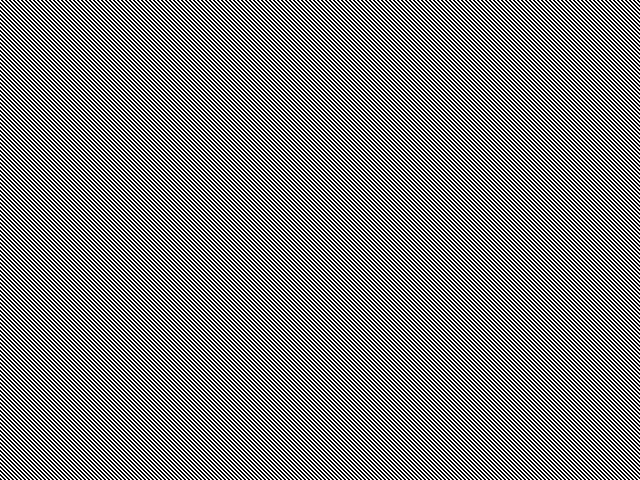

In [63]:
i

In [ ]:
print(tf.__version__)
print(dir(tf.scatter_update))

In [32]:
r = tf.reduce_sum(tf.math.square(h) + tf.math.square(v), axis=2) 

In [31]:
_lambda / beta

0.5

In [36]:
tf.math.real(r) < 2 

<tf.Tensor: id=480, shape=(480, 640), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

In [79]:
S_complex

<tf.Tensor: id=11212, shape=(480, 640, 3), dtype=complex64, numpy=
array([[[0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        [0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        [0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        ...,
        [0.33203125+0.j, 0.41015625+0.j, 0.4375    +0.j],
        [0.34765625+0.j, 0.41796875+0.j, 0.4453125 +0.j],
        [0.34375   +0.j, 0.41015625+0.j, 0.44140625+0.j]],

       [[0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        [0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        [0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        ...,
        [0.328125  +0.j, 0.4296875 +0.j, 0.44921875+0.j],
        [0.328125  +0.j, 0.41796875+0.j, 0.44140625+0.j],
        [0.3359375 +0.j, 0.421875  +0.j, 0.4453125 +0.j]],

       [[0.05859375+0.j, 0.0625    +0.j, 0.03125   +0.j],
        [0.0546875 +0.j, 0.05859375+0.j, 0.03125   +0.j],
        [0.0546875 +0.j, 0.05859375+0.j, 0.02734375+0.j],
        ...,
        [0.32421875+